In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score

In [2]:
df = pd.read_csv("New Final Candidates Cleaned.csv")
pd.set_option('display.max_columns', None)
df.head(5)

,Unnamed: 0,geo_name,year,votes,vote_share,incumbent,winner,prob_democrat,prob_republican,pid_est,prob_male,prob_female,gender_est,prob_black,prob_white,prob_hispanic,prob_asian,prob_other,race_est,contributor.cfscore,percent_women,percent_white,percent_black,percent_hispanic,percent_asian_american,candidate_count,UE 12Mo Avg,UE 12Mo Max,UE 12Mo Min,UE 3Mo Avg,UE 3Mo Max,UE 3Mo Min,CPI 12Mo Avg,CPI 12Mo Max,CPI 12Mo Min,CPI 3Mo Avg,CPI 3Mo Max,CPI 3Mo Min,pid_est_knn,gender_est_knn,race_est_knn
0,3244,Abilene,1996,3826.0,0.89,1.0,1,0.050000,0.950000,Republican,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,1.020000,0.502459,0.798016,0.080899,0.178764,0.101590,2,5.591667,5.7,5.5,5.533333,5.6,5.5,153.791667,156.10,152.10,155.533333,156.10,155.000,1.000000,1.0,2.0
1,4719,Abilene,1996,451.0,0.11,0.0,0,0.573265,0.426735,Unknown,1.0,0.0,Male,0.03,0.97,0.0,0.0,0.0,Caucasian,-0.145909,0.502459,0.798016,0.080899,0.178764,0.101590,2,5.591667,5.7,5.5,5.533333,5.6,5.5,153.791667,156.10,152.10,155.533333,156.10,155.000,0.417135,1.0,2.0
2,530,Akron,2003,26967.0,0.71,1.0,1,1.000000,0.000000,Democrat,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,-0.850000,0.520664,0.657211,0.293766,0.014515,0.022447,2,6.025000,6.3,5.8,6.066667,6.1,6.0,183.400000,185.10,181.50,184.833333,185.10,184.500,0.000000,1.0,2.0
3,1480,Akron,2003,11171.0,0.29,0.0,0,0.000000,1.000000,Republican,1.0,0.0,Male,0.58,0.41,0.0,0.0,0.0,Black,0.550000,0.520664,0.657211,0.293766,0.014515,0.022447,2,6.025000,6.3,5.8,6.066667,6.1,6.0,183.400000,185.10,181.50,184.833333,185.10,184.500,1.000000,1.0,1.0
4,419,Akron,2011,31674.0,0.70,1.0,1,1.000000,0.000000,Democrat,1.0,0.0,Male,0.00,1.00,0.0,0.0,0.0,Caucasian,-0.362011,0.517043,0.619837,0.313499,0.022048,0.030919,2,9.100000,9.8,8.8,8.933333,9.0,8.8,223.728833,226.75,219.59,226.484333,226.75,226.106,0.000000,1.0,2.0


# Hyperparameter Tuning with Grid Search CV

In [3]:
def rand_forest_grid(cat_features, num_features):
    X = df[cat_features + num_features]
    Y = df["winner"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('scaler', StandardScaler())
            ]), numeric_features),
            ('cat', Pipeline(steps=[
                ('onehot', OneHotEncoder())
            ]), categorical_features)
        ])
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    param_grid = {
        'classifier__n_estimators': [10, 50, 100], # Number of trees, default = 100
        'classifier__max_features': [None, 'sqrt'], # Maximum number of features, default = 'sqrt'
        'classifier__min_samples_leaf': [1, 5, 10], # Minimum leaf node size, default = 1
        'classifier__max_depth': [None, 5, 10], # Maximum tree depth, default = None
        'classifier__criterion': ['gini', 'entropy'], # Split criterion, default = 'gini'
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV (
        estimator  = model_pipeline,
        param_grid = param_grid,
                cv = cv,
             refit = 'PR_AUC',
            n_jobs = -1,
           verbose = 2,
        return_train_score=True,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'PR_AUC': 'average_precision'
        }
    )

    print("\nStarting grid search...")
    # Fit the grid search to the data
    grid_search.fit(X_train, Y_train)
    
    # Print best parameters and score
    print("\nBest parameters:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Evaluate on test set
    Y_pred = best_model.predict(X_test)
    Y_prob = best_model.predict_proba(X_test)[:, 1]
    
    print("\nTest Set Evaluation:")
    print(classification_report(Y_test, Y_pred))
    
    print("AUC: " + str(roc_auc_score(Y_test, Y_pred)))

    return Y_test, Y_pred

# Feature Selection

### Base Model

In [4]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.7863

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### Demographic Information as KNN Features

In [5]:
categorical_features = ["incumbent"]
numeric_features = ["candidate_count", "pid_est_knn", "gender_est_knn", "race_est_knn"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.7843

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### Demographic Information as Numeric Features

In [6]:
categorical_features = ["incumbent"]
numeric_features = ["candidate_count", "prob_democrat", "prob_republican", "prob_male", "prob_female", "prob_black",
                    "prob_white", "prob_hispanic", "prob_asian", "prob_other"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 10}

Best cross-validation score: 0.8140

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.77      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8466962022007893


### Contributor Ideology Score

In [7]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "contributor.cfscore"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 50}

Best cross-validation score: 0.8028

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### Population Gender Composition

In [8]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "percent_women"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.8058

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### Population Race Composition

In [9]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "percent_black", "percent_white",
                    "percent_hispanic", "percent_asian_american"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.8069

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### 12-Month Consumer Price Index

In [10]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "CPI 12Mo Avg", "CPI 12Mo Max", "CPI 12Mo Min"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.8110

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### 3-Month Consumer Price Index

In [11]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "CPI 3Mo Avg", "CPI 3Mo Max", "CPI 3Mo Min"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.8095

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### 12-Month Unemployment Rate

In [12]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "UE 12Mo Avg", "UE 12Mo Max", "UE 12Mo Min"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 50}

Best cross-validation score: 0.8029

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


### 3-Month Unemployment Rate

In [13]:
categorical_features = ["pid_est", "gender_est", "race_est", "incumbent"]
numeric_features = ["candidate_count", "UE 3Mo Avg", "UE 3Mo Max", "UE 3Mo Min"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}

Best cross-validation score: 0.8110

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.78      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8453762513395541


# Best Features

### Without Incumbent

In [14]:
categorical_features = []
numeric_features = ["candidate_count", "prob_democrat", "prob_republican", "prob_male", "prob_female", "prob_black",
                    "prob_white", "prob_hispanic", "prob_asian", "prob_other"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 50}

Best cross-validation score: 0.7284

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       654
           1       0.68      0.81      0.74       351

    accuracy                           0.80      1005
   macro avg       0.78      0.80      0.79      1005
weighted avg       0.82      0.80      0.81      1005

AUC: 0.8049609242269793


### With Incumbent

In [15]:
categorical_features = ["incumbent"]
numeric_features = ["candidate_count", "prob_democrat", "prob_republican", "prob_male", "prob_female", "prob_black",
                    "prob_white", "prob_hispanic", "prob_asian", "prob_other"]

model_Y_test, model_Y_pred = rand_forest_grid(categorical_features, numeric_features)


Starting grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters:
{'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 10}

Best cross-validation score: 0.8140

Test Set Evaluation:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       654
           1       0.77      0.82      0.80       351

    accuracy                           0.85      1005
   macro avg       0.84      0.85      0.84      1005
weighted avg       0.86      0.85      0.85      1005

AUC: 0.8466962022007893


Text(0.5, 1.0, 'Confusion Matrix')

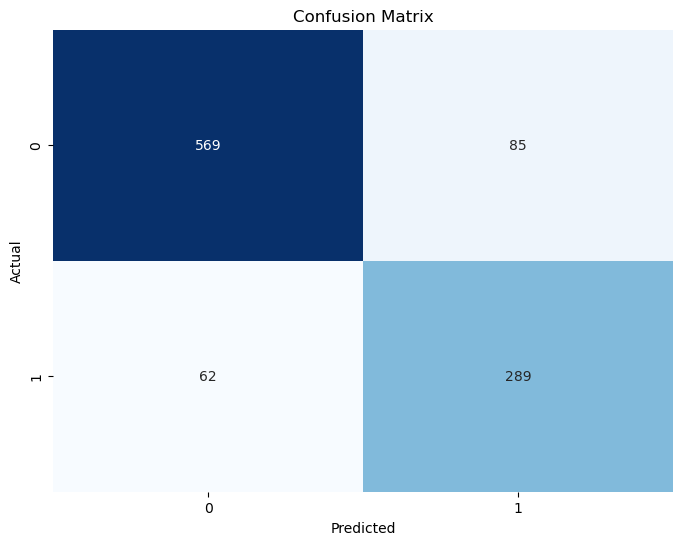

In [16]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(model_Y_test, model_Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

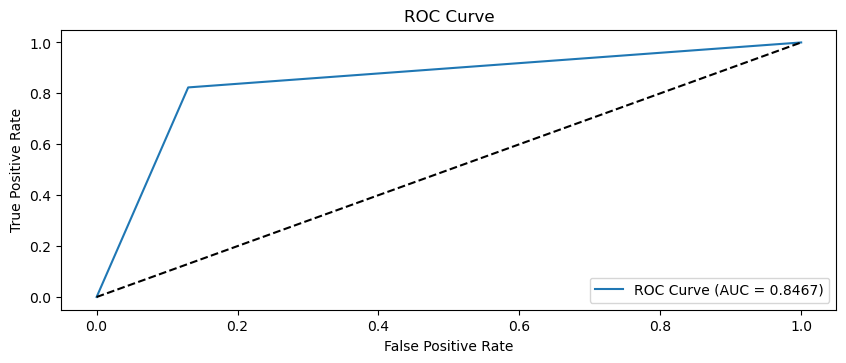

In [17]:
roc_auc = roc_auc_score(model_Y_test, model_Y_pred)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(model_Y_test, model_Y_pred)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')